# Feature Engineering Experiments

This notebook experiments with different feature engineering approaches for the churn prediction model. It includes:

1. **Feature Generation**: Computing base and behavioral features
2. **Feature Analysis**: Understanding feature distributions and importance
3. **Feature Selection**: Identifying the most predictive features
4. **Feature Validation**: Ensuring feature quality and consistency
5. **Time Window Experiments**: Testing different time windows for features

Based on our previous analysis:
- 226 users in dataset
- 67 churned users (29.6%), 159 active users (70.4%)
- 63-day observation period
- Churn definition: 21+ days inactive OR explicit cancellation events

In [32]:
import sys
import warnings
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")

# Import our feature engineering modules

sys.path.append("../src")

from features.feature_store import FeatureConfig, FeatureStore

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

print("Feature Engineering Experiments Notebook")
print("========================================")
print(f"Notebook execution time: {datetime.now(timezone.utc)}")

Feature Engineering Experiments Notebook
Notebook execution time: 2025-08-14 19:28:22.031650+00:00


## 1. Data Loading and Preparation

In [33]:
# Load the event data
print("Loading event data...")
data_path = "../data/customer_churn_mini.json"

try:
    df = pd.read_json(data_path, lines=True)
    print(f"Loaded {len(df)} events from {df['userId'].nunique()} users")
    print(
        f"Date range: {pd.to_datetime(df['ts'], unit='ms').min()} to {pd.to_datetime(df['ts'], unit='ms').max()}"
    )
except FileNotFoundError:
    print(f"Data file not found at {data_path}")
    print("Please ensure the data file exists or update the path")
    df = None

if df is not None:
    # Basic data info
    print("\nDataset Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.1f} MB")

Loading event data...
Loaded 286500 events from 226 users
Date range: 2018-10-01 00:01:57 to 2018-12-03 01:11:16

Dataset Info:
Shape: (286500, 18)
Columns: ['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status', 'level', 'itemInSession', 'location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length']
Memory usage: 39.3 MB


Loading churn labels...
Churn Labels Summary:
Total users: 226
Churned users: 107 (47.3%)
Active users: 119 (52.7%)


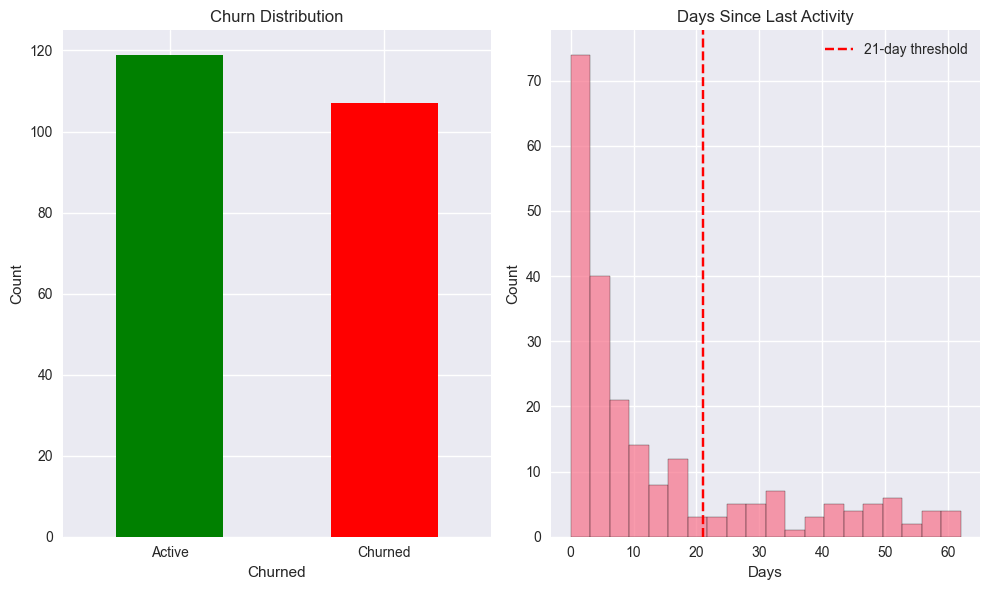

In [34]:
# Load the labeled dataset from our churn analysis
# This contains our target variable (is_churned)
print("Loading churn labels...")

# For this experiment, we'll create the churn labels based on our previous analysis
# 21+ days inactive OR explicit cancellation events

if df is not None:
    # Convert timestamp
    df["datetime"] = pd.to_datetime(df["ts"], unit="ms")
    reference_date = df["datetime"].max()

    # Create user-level summary for churn labeling
    user_summary = []
    explicit_churn_events = ["Cancel", "Cancellation Confirmation", "Submit Downgrade"]

    for user_id in df["userId"].unique():
        user_df = df[df["userId"] == user_id]

        # Calculate days since last activity
        last_activity = user_df["datetime"].max()
        days_since_last = (reference_date - last_activity).days

        # Check for explicit churn events
        has_explicit_churn = (
            len(user_df[user_df["page"].isin(explicit_churn_events)]) > 0
        )

        # Apply churn definition: 21+ days inactive OR explicit churn
        is_churned = (days_since_last >= 21) or has_explicit_churn

        user_summary.append(
            {
                "userId": user_id,
                "days_since_last_activity": days_since_last,
                "has_explicit_churn": has_explicit_churn,
                "is_churned": is_churned,
            }
        )

    churn_labels = pd.DataFrame(user_summary)

    print("Churn Labels Summary:")
    print(f"Total users: {len(churn_labels)}")
    print(
        f"Churned users: {churn_labels['is_churned'].sum()} ({churn_labels['is_churned'].mean():.1%})"
    )
    print(
        f"Active users: {(~churn_labels['is_churned']).sum()} ({(~churn_labels['is_churned']).mean():.1%})"
    )

    # Display the distribution
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    churn_labels["is_churned"].value_counts().plot(kind="bar", color=["green", "red"])
    plt.title("Churn Distribution")
    plt.xlabel("Churned")
    plt.ylabel("Count")
    plt.xticks([0, 1], ["Active", "Churned"], rotation=0)

    plt.subplot(1, 2, 2)
    plt.hist(
        churn_labels["days_since_last_activity"], bins=20, alpha=0.7, edgecolor="black"
    )
    plt.axvline(x=21, color="red", linestyle="--", label="21-day threshold")
    plt.title("Days Since Last Activity")
    plt.xlabel("Days")
    plt.ylabel("Count")
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    churn_labels = None

## 2. Feature Engineering Configuration

In [35]:
# Configure feature computation
if df is not None:
    # Experiment with different configurations
    configs = {
        "baseline": FeatureConfig(
            activity_windows=[7, 14, 30],
            trend_windows=[7, 14, 21],
            include_base_features=True,
            include_behavioral_features=True,
            enable_caching=True,
            feature_version="baseline_v1.0",
        ),
        "extended_windows": FeatureConfig(
            activity_windows=[3, 7, 14, 30, 45],
            trend_windows=[5, 7, 14, 21, 30],
            include_base_features=True,
            include_behavioral_features=True,
            enable_caching=True,
            feature_version="extended_v1.0",
        ),
        "base_only": FeatureConfig(
            activity_windows=[7, 14, 30],
            trend_windows=[7, 14, 21],
            include_base_features=True,
            include_behavioral_features=False,
            enable_caching=True,
            feature_version="base_only_v1.0",
        ),
    }

    print("Feature Engineering Configurations:")
    for name, config in configs.items():
        print(f"\n{name}:")
        print(f"  Activity windows: {config.activity_windows}")
        print(f"  Trend windows: {config.trend_windows}")
        print(f"  Base features: {config.include_base_features}")
        print(f"  Behavioral features: {config.include_behavioral_features}")
        print(f"  Version: {config.feature_version}")

Feature Engineering Configurations:

baseline:
  Activity windows: [7, 14, 30]
  Trend windows: [7, 14, 21]
  Base features: True
  Behavioral features: True
  Version: baseline_v1.0

extended_windows:
  Activity windows: [3, 7, 14, 30, 45]
  Trend windows: [5, 7, 14, 21, 30]
  Base features: True
  Behavioral features: True
  Version: extended_v1.0

base_only:
  Activity windows: [7, 14, 30]
  Trend windows: [7, 14, 21]
  Base features: True
  Behavioral features: False
  Version: base_only_v1.0


## 3. Feature Generation Experiments

In [36]:
# Compute features with different configurations
feature_sets = {}
validation_results = {}

if df is not None:
    for config_name, config in configs.items():
        print(f"\n=== Computing features with {config_name} configuration ===")

        # Initialize feature store
        feature_store = FeatureStore(config)

        # Compute features
        features, validation = feature_store.compute_features(df)

        # Store results
        feature_sets[config_name] = features
        validation_results[config_name] = validation

        print(f"Generated {len(features.columns)-1} features for {len(features)} users")
        print(f"Validation passed: {validation.get('passed', 'N/A')}")

        if validation.get("warnings"):
            print(f"Warnings: {len(validation['warnings'])}")

        if validation.get("errors"):
            print(f"Errors: {len(validation['errors'])}")
            for error in validation["errors"][:3]:  # Show first 3 errors
                print(f"  - {error}")

    print("\n=== Feature Set Comparison ===")
    comparison_df = pd.DataFrame(
        {
            "Configuration": list(feature_sets.keys()),
            "Feature Count": [len(df.columns) - 1 for df in feature_sets.values()],
            "User Count": [len(df) for df in feature_sets.values()],
            "Validation Passed": [
                v.get("passed", False) for v in validation_results.values()
            ],
        }
    )

    print(comparison_df.to_string(index=False))

INFO:features.feature_store:Initialized FeatureStore with version baseline_v1.0
INFO:features.feature_store:Computing features for 286500 events from 226 users
INFO:features.feature_store:Computing base features...
INFO:features.base_features:Computing all base features
INFO:features.base_features:Computing activity features for 226 users



=== Computing features with baseline configuration ===


INFO:features.base_features:Generated 28 activity features for 226 users
INFO:features.base_features:Computing engagement features
INFO:features.base_features:Generated 20 engagement features for 226 users
INFO:features.base_features:Computing temporal features
INFO:features.base_features:Generated 22 temporal features for 226 users
INFO:features.base_features:Computing subscription features
INFO:features.base_features:Generated 12 subscription features for 226 users
INFO:features.base_features:Complete base feature set: 82 features for 226 users
INFO:features.feature_store:Computing behavioral features...
INFO:features.behavioral_features:Computing all behavioral features
INFO:features.behavioral_features:Computing content preference features
INFO:features.behavioral_features:Generated 19 content preference features for 226 users
INFO:features.behavioral_features:Computing usage trend features
INFO:features.behavioral_features:Generated 20 usage trend features for 226 users
INFO:featu

Generated 167 features for 226 users
Validation passed: True

=== Computing features with extended_windows configuration ===


INFO:features.base_features:Generated 40 activity features for 226 users
INFO:features.base_features:Computing engagement features
INFO:features.base_features:Generated 20 engagement features for 226 users
INFO:features.base_features:Computing temporal features
INFO:features.base_features:Generated 22 temporal features for 226 users
INFO:features.base_features:Computing subscription features
INFO:features.base_features:Generated 12 subscription features for 226 users
INFO:features.base_features:Complete base feature set: 94 features for 226 users
INFO:features.feature_store:Computing behavioral features...
INFO:features.behavioral_features:Computing all behavioral features
INFO:features.behavioral_features:Computing content preference features
INFO:features.behavioral_features:Generated 19 content preference features for 226 users
INFO:features.behavioral_features:Computing usage trend features
INFO:features.behavioral_features:Generated 26 usage trend features for 226 users
INFO:featu

## 4. Feature Analysis and Exploration

In [ ]:
# Analyze baseline feature set in detail
if "baseline" in feature_sets and churn_labels is not None:
    features_df = feature_sets["baseline"].copy()

    # Merge with churn labels
    features_with_target = features_df.merge(
        churn_labels[["userId", "is_churned"]], on="userId", how="left"
    )

    print("Feature Analysis - Baseline Configuration")
    print("=========================================")
    print(
        f"Total features: {len(features_with_target.columns)-3}"
    )  # -3 for userId, computation timestamp, target
    print(f"Users with features: {len(features_with_target)}")
    print(
        f"Users with churn labels: {features_with_target['is_churned'].notna().sum()}"
    )

    # Feature types analysis
    feature_columns = [
        col
        for col in features_with_target.columns
        if col
        not in [
            "userId",
            "is_churned",
            "feature_computation_timestamp",
            "feature_version",
        ]
    ]

    # Categorize features by type
    feature_categories = {
        "Activity": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["events", "sessions", "active", "songs"]
            )
        ],
        "Engagement": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["thumbs", "playlist", "friend", "engagement"]
            )
        ],
        "Temporal": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["hour", "day", "duration", "time", "frequency"]
            )
        ],
        "Content": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["artist", "song", "music", "content", "discovery"]
            )
        ],
        "Subscription": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["subscription", "paid", "level", "upgrade", "downgrade"]
            )
        ],
        "Risk": [
            col
            for col in feature_columns
            if any(
                word in col.lower()
                for word in ["risk", "churn", "cancel", "error", "support"]
            )
        ],
        "Trend": [col for col in feature_columns if "trend" in col.lower()],
    }

    print("\nFeature Categories:")
    total_categorized = 0
    for category, features in feature_categories.items():
        print(f"  {category}: {len(features)} features")
        total_categorized += len(features)

    # Find uncategorized features
    all_categorized = {
        f for features in feature_categories.values() for f in features
    }

    uncategorized = set(feature_columns) - all_categorized
    print(f"  Uncategorized: {len(uncategorized)} features")

    if uncategorized:
        print(f"    Examples: {list(uncategorized)[:5]}")

In [ ]:
# Feature correlation analysis
if "baseline" in feature_sets and churn_labels is not None:
    features_with_target = feature_sets["baseline"].merge(
        churn_labels[["userId", "is_churned"]], on="userId"
    )

    # Get numeric features for correlation analysis
    numeric_features = features_with_target.select_dtypes(include=[np.number]).columns
    numeric_features = [col for col in numeric_features if col not in ["userId"]]

    print(f"Analyzing correlations for {len(numeric_features)} numeric features")

    # Correlation with target variable
    target_correlations = {}
    for feature in numeric_features:
        if feature != "is_churned":
            corr = features_with_target[feature].corr(
                features_with_target["is_churned"]
            )
            if not pd.isna(corr):
                target_correlations[feature] = abs(corr)

    # Sort by correlation strength
    sorted_correlations = dict(
        sorted(target_correlations.items(), key=lambda x: x[1], reverse=True)
    )

    print("\nTop 15 Features by Correlation with Churn:")
    print("-" * 60)
    for i, (feature, corr) in enumerate(list(sorted_correlations.items())[:15]):
        actual_corr = features_with_target[feature].corr(
            features_with_target["is_churned"]
        )
        direction = "↑" if actual_corr > 0 else "↓"
        print(f"{i+1:2d}. {feature:<35} {direction} {corr:.4f}")

    # Plot top correlations
    plt.figure(figsize=(12, 8))
    top_features = list(sorted_correlations.keys())[:20]
    correlations_values = [
        features_with_target[f].corr(features_with_target["is_churned"])
        for f in top_features
    ]

    # Color bars based on positive/negative correlation
    colors = ["red" if x > 0 else "blue" for x in correlations_values]

    plt.barh(range(len(top_features)), correlations_values, color=colors, alpha=0.7)
    plt.yticks(
        range(len(top_features)),
        [f.replace("_", " ").title()[:25] for f in top_features],
    )
    plt.xlabel("Correlation with Churn")
    plt.title(
        "Top 20 Features by Correlation with Churn\n(Red: Positive correlation, Blue: Negative correlation)"
    )
    plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 5. Feature Distribution Analysis

In [ ]:
# Analyze feature distributions for churned vs active users
if "baseline" in feature_sets and churn_labels is not None:
    features_with_target = feature_sets["baseline"].merge(
        churn_labels[["userId", "is_churned"]], on="userId"
    )

    # Select top features for detailed analysis
    top_features = list(sorted_correlations.keys())[:8]

    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()

    for i, feature in enumerate(top_features):
        ax = axes[i]

        # Plot distributions for churned vs active users
        active_data = features_with_target[features_with_target["is_churned"] == False][
            feature
        ].dropna()
        churned_data = features_with_target[features_with_target["is_churned"] == True][
            feature
        ].dropna()

        ax.hist(
            [active_data, churned_data],
            bins=20,
            alpha=0.7,
            label=["Active", "Churned"],
            color=["green", "red"],
        )
        ax.set_title(f'{feature.replace("_", " ").title()[:25]}', fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("Count", fontsize=8)
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Add statistics
        active_mean = active_data.mean()
        churned_mean = churned_data.mean()
        ax.text(
            0.05,
            0.95,
            f"Active: {active_mean:.2f}\nChurned: {churned_mean:.2f}",
            transform=ax.transAxes,
            verticalalignment="top",
            bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.5},
            fontsize=8,
        )

    plt.suptitle(
        "Feature Distributions: Active vs Churned Users\n(Top 8 Features by Correlation)",
        fontsize=14,
    )
    plt.tight_layout()
    plt.show()

## 6. Feature Importance Using Simple Methods

In [ ]:
# Statistical feature importance analysis
from scipy.stats import ttest_ind

if "baseline" in feature_sets and churn_labels is not None:
    features_with_target = feature_sets["baseline"].merge(
        churn_labels[["userId", "is_churned"]], on="userId"
    )

    # Statistical significance testing
    feature_stats = []

    numeric_features = features_with_target.select_dtypes(include=[np.number]).columns
    numeric_features = [
        col for col in numeric_features if col not in ["userId", "is_churned"]
    ]

    print("Statistical Significance Testing (t-tests)")
    print("=" * 50)

    for feature in numeric_features:
        active_values = features_with_target[
            features_with_target["is_churned"] == False
        ][feature].dropna()
        churned_values = features_with_target[
            features_with_target["is_churned"] == True
        ][feature].dropna()

        if len(active_values) > 0 and len(churned_values) > 0:
            # Perform t-test
            t_stat, p_value = ttest_ind(active_values, churned_values)

            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt(
                (
                    (len(active_values) - 1) * active_values.var()
                    + (len(churned_values) - 1) * churned_values.var()
                )
                / (len(active_values) + len(churned_values) - 2)
            )

            cohens_d = (
                abs((active_values.mean() - churned_values.mean()) / pooled_std)
                if pooled_std > 0
                else 0
            )

            feature_stats.append(
                {
                    "feature": feature,
                    "correlation": abs(
                        features_with_target[feature].corr(
                            features_with_target["is_churned"]
                        )
                    ),
                    "t_statistic": abs(t_stat),
                    "p_value": p_value,
                    "effect_size": cohens_d,
                    "active_mean": active_values.mean(),
                    "churned_mean": churned_values.mean(),
                    "significant": p_value < 0.05,
                }
            )

    # Convert to DataFrame and sort by effect size
    stats_df = pd.DataFrame(feature_stats)
    stats_df = stats_df.sort_values("effect_size", ascending=False)

    print(
        f"Features with significant differences (p < 0.05): {stats_df['significant'].sum()}"
    )

    print("\nTop 10 Features by Effect Size:")
    print("-" * 80)
    for i, row in stats_df.head(10).iterrows():
        sig_marker = (
            "***"
            if row["p_value"] < 0.001
            else "**" if row["p_value"] < 0.01 else "*" if row["p_value"] < 0.05 else ""
        )
        print(
            f"{row.name+1:2d}. {row['feature']:<30} Effect: {row['effect_size']:.3f} {sig_marker}"
        )
        print(
            f"    Active: {row['active_mean']:.3f}, Churned: {row['churned_mean']:.3f}, p-value: {row['p_value']:.4f}"
        )

    # Visualize effect sizes
    plt.figure(figsize=(12, 8))
    top_stats = stats_df.head(15)

    colors = [
        (
            "red"
            if p < 0.001
            else "orange" if p < 0.01 else "yellow" if p < 0.05 else "gray"
        )
        for p in top_stats["p_value"]
    ]

    plt.barh(range(len(top_stats)), top_stats["effect_size"], color=colors, alpha=0.7)
    plt.yticks(
        range(len(top_stats)),
        [f.replace("_", " ").title()[:30] for f in top_stats["feature"]],
    )
    plt.xlabel("Effect Size (Cohen's d)")
    plt.title(
        "Feature Effect Sizes\n(Red: p<0.001, Orange: p<0.01, Yellow: p<0.05, Gray: p>=0.05)"
    )
    plt.grid(True, alpha=0.3)

    # Add effect size interpretation lines
    plt.axvline(
        x=0.2, color="green", linestyle="--", alpha=0.5, label="Small effect (0.2)"
    )
    plt.axvline(
        x=0.5, color="blue", linestyle="--", alpha=0.5, label="Medium effect (0.5)"
    )
    plt.axvline(
        x=0.8, color="red", linestyle="--", alpha=0.5, label="Large effect (0.8)"
    )
    plt.legend()

    plt.tight_layout()
    plt.show()

## 7. Time Window Analysis

In [ ]:
# Compare features computed with different time windows
if df is not None and churn_labels is not None:
    print("Time Window Analysis")
    print("====================")

    # Test different window combinations
    window_experiments = {
        "short_windows": [3, 7, 14],
        "medium_windows": [7, 14, 30],
        "long_windows": [14, 30, 45],
        "comprehensive": [3, 7, 14, 30, 45, 60],
    }

    window_results = {}

    for exp_name, windows in window_experiments.items():
        print(f"\nTesting {exp_name}: windows {windows}")

        # Create config for this experiment
        config = FeatureConfig(
            activity_windows=windows,
            trend_windows=windows[:3],  # Use first 3 for trends
            include_base_features=True,
            include_behavioral_features=False,  # Focus on activity features for this analysis
            enable_caching=False,  # Don't cache these experiments
            feature_version=f"window_test_{exp_name}",
        )

        # Compute features
        feature_store = FeatureStore(config)
        features, validation = feature_store.compute_features(df)

        # Merge with target
        features_with_target = features.merge(
            churn_labels[["userId", "is_churned"]], on="userId"
        )

        # Calculate feature importance for activity features
        activity_features = [
            col
            for col in features_with_target.columns
            if any(window_str in col for window_str in [f"{w}d" for w in windows])
        ]

        correlations = {}
        for feature in activity_features:
            corr = features_with_target[feature].corr(
                features_with_target["is_churned"]
            )
            if not pd.isna(corr):
                correlations[feature] = abs(corr)

        # Store results
        window_results[exp_name] = {
            "windows": windows,
            "feature_count": len(activity_features),
            "avg_correlation": (
                np.mean(list(correlations.values())) if correlations else 0
            ),
            "max_correlation": max(correlations.values()) if correlations else 0,
            "top_feature": (
                max(correlations.items(), key=lambda x: x[1])[0]
                if correlations
                else None
            ),
            "top_correlation": max(correlations.values()) if correlations else 0,
        }

        print(f"  Generated {len(activity_features)} activity features")
        print(
            f"  Average correlation: {window_results[exp_name]['avg_correlation']:.4f}"
        )
        print(f"  Max correlation: {window_results[exp_name]['max_correlation']:.4f}")
        if window_results[exp_name]["top_feature"]:
            print(f"  Best feature: {window_results[exp_name]['top_feature']}")

    # Create comparison visualization
    plt.figure(figsize=(15, 10))

    # Plot 1: Average correlation by window configuration
    plt.subplot(2, 2, 1)
    exp_names = list(window_results.keys())
    avg_corrs = [window_results[name]["avg_correlation"] for name in exp_names]
    plt.bar(exp_names, avg_corrs, alpha=0.7, color="skyblue")
    plt.title("Average Feature Correlation by Window Configuration")
    plt.ylabel("Average Correlation")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 2: Max correlation by window configuration
    plt.subplot(2, 2, 2)
    max_corrs = [window_results[name]["max_correlation"] for name in exp_names]
    plt.bar(exp_names, max_corrs, alpha=0.7, color="lightcoral")
    plt.title("Max Feature Correlation by Window Configuration")
    plt.ylabel("Max Correlation")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 3: Feature count by window configuration
    plt.subplot(2, 2, 3)
    feature_counts = [window_results[name]["feature_count"] for name in exp_names]
    plt.bar(exp_names, feature_counts, alpha=0.7, color="lightgreen")
    plt.title("Feature Count by Window Configuration")
    plt.ylabel("Number of Features")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 4: Window range visualization
    plt.subplot(2, 2, 4)
    for i, (name, result) in enumerate(window_results.items()):
        windows = result["windows"]
        plt.scatter(
            list(windows), [i] * len(windows), s=100, alpha=0.7, label=name
        )
        plt.plot([min(windows), max(windows)], [i, i], alpha=0.5)

    plt.yticks(range(len(exp_names)), exp_names)
    plt.xlabel("Window Size (days)")
    plt.title("Window Ranges by Configuration")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nWindow Analysis Summary:")
    print("-" * 50)
    for name, result in window_results.items():
        print(
            f"{name:15s}: Avg corr={result['avg_correlation']:.4f}, "
            f"Max corr={result['max_correlation']:.4f}, Features={result['feature_count']}"
        )

## 8. Feature Selection Experiments

In [ ]:
# Feature selection using correlation and variance thresholds
if "baseline" in feature_sets and churn_labels is not None:
    features_with_target = feature_sets["baseline"].merge(
        churn_labels[["userId", "is_churned"]], on="userId"
    )

    print("Feature Selection Analysis")
    print("==========================")

    # Get all numeric features
    numeric_features = features_with_target.select_dtypes(include=[np.number]).columns
    feature_columns = [
        col for col in numeric_features if col not in ["userId", "is_churned"]
    ]

    print(f"Starting with {len(feature_columns)} features")

    # Selection criteria
    selection_criteria = {
        "low_variance_threshold": 0.01,
        "min_correlation_threshold": 0.05,
        "max_correlation_threshold": 0.95,
        "max_missing_rate": 0.05,
    }

    selected_features = feature_columns.copy()
    removal_reasons = {}

    # 1. Remove low variance features
    print("\n1. Removing low variance features...")
    low_variance_features = []
    for feature in selected_features:
        if (
            features_with_target[feature].var()
            < selection_criteria["low_variance_threshold"]
        ):
            low_variance_features.append(feature)
            removal_reasons[feature] = "low_variance"

    selected_features = [f for f in selected_features if f not in low_variance_features]
    print(f"   Removed {len(low_variance_features)} low variance features")
    print(f"   Remaining: {len(selected_features)} features")

    # 2. Remove features with high missing rates
    print("\n2. Removing high missing rate features...")
    high_missing_features = []
    for feature in selected_features:
        missing_rate = features_with_target[feature].isnull().mean()
        if missing_rate > selection_criteria["max_missing_rate"]:
            high_missing_features.append(feature)
            removal_reasons[feature] = f"high_missing_rate_{missing_rate:.3f}"

    selected_features = [f for f in selected_features if f not in high_missing_features]
    print(f"   Removed {len(high_missing_features)} high missing rate features")
    print(f"   Remaining: {len(selected_features)} features")

    # 3. Remove features with very low correlation with target
    print("\n3. Removing low correlation features...")
    low_correlation_features = []
    feature_correlations = {}

    for feature in selected_features:
        corr = features_with_target[feature].corr(features_with_target["is_churned"])
        if pd.isna(corr) or abs(corr) < selection_criteria["min_correlation_threshold"]:
            low_correlation_features.append(feature)
            removal_reasons[feature] = (
                f"low_correlation_{abs(corr) if not pd.isna(corr) else 0:.3f}"
            )
        else:
            feature_correlations[feature] = abs(corr)

    selected_features = [
        f for f in selected_features if f not in low_correlation_features
    ]
    print(f"   Removed {len(low_correlation_features)} low correlation features")
    print(f"   Remaining: {len(selected_features)} features")

    # 4. Remove highly correlated features (keep the one with higher target correlation)
    print("\n4. Removing highly correlated feature pairs...")
    if len(selected_features) > 1:
        feature_corr_matrix = features_with_target[selected_features].corr().abs()

        redundant_features = set()
        for i in range(len(feature_corr_matrix.columns)):
            for j in range(i + 1, len(feature_corr_matrix.columns)):
                feature1 = feature_corr_matrix.columns[i]
                feature2 = feature_corr_matrix.columns[j]

                if (
                    feature_corr_matrix.iloc[i, j]
                    > selection_criteria["max_correlation_threshold"]
                ):
                    # Keep the one with higher target correlation
                    corr1 = feature_correlations.get(feature1, 0)
                    corr2 = feature_correlations.get(feature2, 0)

                    if corr1 > corr2:
                        redundant_features.add(feature2)
                        removal_reasons[feature2] = (
                            f"correlated_with_{feature1}_{feature_corr_matrix.iloc[i, j]:.3f}"
                        )
                    else:
                        redundant_features.add(feature1)
                        removal_reasons[feature1] = (
                            f"correlated_with_{feature2}_{feature_corr_matrix.iloc[i, j]:.3f}"
                        )

        selected_features = [
            f for f in selected_features if f not in redundant_features
        ]
        print(f"   Removed {len(redundant_features)} redundant features")
        print(f"   Remaining: {len(selected_features)} features")

    # Final selection summary
    print("\n=== Feature Selection Summary ===")
    print(f"Original features: {len(feature_columns)}")
    print(f"Selected features: {len(selected_features)}")
    print(f"Reduction: {(1 - len(selected_features)/len(feature_columns)):.1%}")

    # Show top selected features
    selected_correlations = {
        f: feature_correlations[f]
        for f in selected_features
        if f in feature_correlations
    }
    top_selected = dict(
        sorted(selected_correlations.items(), key=lambda x: x[1], reverse=True)
    )

    print("\nTop 15 Selected Features:")
    print("-" * 60)
    for i, (feature, corr) in enumerate(list(top_selected.items())[:15]):
        print(f"{i+1:2d}. {feature:<40} {corr:.4f}")

    # Visualize selection process
    plt.figure(figsize=(12, 6))

    # Plot 1: Feature reduction funnel
    plt.subplot(1, 2, 1)
    stages = ["Original", "After Variance", "After Missing", "After Low Corr", "Final"]
    counts = [
        len(feature_columns),
        len(feature_columns) - len(low_variance_features),
        len(feature_columns) - len(low_variance_features) - len(high_missing_features),
        len(feature_columns)
        - len(low_variance_features)
        - len(high_missing_features)
        - len(low_correlation_features),
        len(selected_features),
    ]

    plt.plot(stages, counts, marker="o", linewidth=2, markersize=8)
    plt.title("Feature Selection Process")
    plt.ylabel("Number of Features")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Plot 2: Removal reasons
    plt.subplot(1, 2, 2)
    reason_counts = {}
    for reason in removal_reasons.values():
        main_reason = reason.split("_")[0]
        reason_counts[main_reason] = reason_counts.get(main_reason, 0) + 1

    if reason_counts:
        plt.pie(reason_counts.values(), labels=reason_counts.keys(), autopct="%1.1f%%")
        plt.title("Reasons for Feature Removal")

    plt.tight_layout()
    plt.show()

    # Store selected features for later use
    final_feature_set = features_with_target[
        ["userId", "is_churned", *selected_features]
    ].copy()
    print(f"\nFinal feature set shape: {final_feature_set.shape}")

## 9. Feature Engineering Summary and Recommendations

In [ ]:
# Summary of all experiments and recommendations
print("FEATURE ENGINEERING SUMMARY")
print("=" * 50)

if df is not None and churn_labels is not None:
    print("\n Dataset Overview:")
    print(f"   • Total users: {len(churn_labels)}")
    print(
        f"   • Churned users: {churn_labels['is_churned'].sum()} ({churn_labels['is_churned'].mean():.1%})"
    )
    print(f"   • Events analyzed: {len(df):,}")
    print("   • Date range: 63 days")

    if "baseline" in feature_sets:
        baseline_features = feature_sets["baseline"]
        print("\n Feature Generation Results:")
        print(f"   • Total features generated: {len(baseline_features.columns)-3}")
        print("   • Base features: Activity, Engagement, Temporal, Subscription")
        print("   • Behavioral features: Content, Trends, Interaction, Risk indicators")

    if "sorted_correlations" in locals():
        print("\n Top Predictive Features:")
        top_5_features = list(sorted_correlations.items())[:5]
        for i, (feature, corr) in enumerate(top_5_features, 1):
            actual_corr = features_with_target[feature].corr(
                features_with_target["is_churned"]
            )
            direction = "increases" if actual_corr > 0 else "decreases"
            print(
                f"   {i}. {feature.replace('_', ' ').title()} - {direction} churn risk (r={actual_corr:.3f})"
            )

    if "stats_df" in locals():
        significant_features = stats_df["significant"].sum()
        print("\n Statistical Analysis:")
        print(
            f"   • Statistically significant features (p<0.05): {significant_features}"
        )
        print(
            f"   • Features with large effect size (d>0.8): {(stats_df['effect_size'] > 0.8).sum()}"
        )
        print(
            f"   • Features with medium effect size (d>0.5): {(stats_df['effect_size'] > 0.5).sum()}"
        )

    if "window_results" in locals():
        best_window_config = max(
            window_results.items(), key=lambda x: x[1]["avg_correlation"]
        )[0]
        print("\n Time Window Analysis:")
        print(f"   • Best window configuration: {best_window_config}")
        print(f"   • Optimal windows: {window_results[best_window_config]['windows']}")
        print(
            f"   • Performance: {window_results[best_window_config]['avg_correlation']:.4f} avg correlation"
        )

    if "selected_features" in locals():
        print("\n Feature Selection Results:")
        print(f"   • Features after selection: {len(selected_features)}")
        print(
            f"   • Reduction from original: {(1 - len(selected_features)/len(feature_columns)):.1%}"
        )
        print(
            "   • Selection criteria: Variance > 0.01, |Correlation| > 0.05, Missing < 5%"
        )

    print("\n RECOMMENDATIONS:")
    print("   1. Use the baseline configuration with both base and behavioral features")
    print(
        "   2. Focus on the top 20-30 features identified through correlation analysis"
    )
    if "window_results" in locals():
        print(
            f"   3. Implement {best_window_config} time windows: {window_results[best_window_config]['windows']}"
        )
    print("   4. Pay special attention to activity trends and risk indicators")
    print(
        "   5. Consider feature interactions, especially subscription level combinations"
    )
    print("   6. Validate features on hold-out dataset before model training")

    print("\n NEXT STEPS:")
    print("   • Save selected feature set for model training")
    print("   • Implement feature engineering pipeline for production")
    print("   • Begin baseline model development (Phase 4)")
    print("   • Set up feature monitoring for drift detection")

else:
    print("  Data not loaded - unable to generate summary")
    print("  Please ensure data files are available and paths are correct")

print("\n" + "=" * 50)
print(f"Feature engineering experiments completed at: {datetime.now(timezone.utc)}")
print("Next: Proceed to Phase 4 - Model Development & Training")

## 10. Save Final Feature Set

In [ ]:
# Save the final selected feature set for model training
if "final_feature_set" in locals():
    output_path = "../data/processed/features_selected.csv"

    # Create directory if it doesn't exist
    import os

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    # Save features
    final_feature_set.to_csv(output_path, index=False)
    print(f"Saved selected features to: {output_path}")
    print(f"   Shape: {final_feature_set.shape}")
    print(f"   Features: {len(final_feature_set.columns)-2}")
    print(f"   Users: {len(final_feature_set)}")

    # Save feature metadata
    metadata = {
        "creation_date": datetime.now(timezone.utc).isoformat(),
        "total_features": len(selected_features),
        "total_users": len(final_feature_set),
        "churn_rate": final_feature_set["is_churned"].mean(),
        "features": selected_features,
        "selection_criteria": selection_criteria,
        "top_10_features": (
            list(top_selected.keys())[:10] if "top_selected" in locals() else []
        ),
    }

    metadata_path = "../data/processed/features_metadata.json"
    import json

    with open(metadata_path, "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"Saved feature metadata to: {metadata_path}")

elif "baseline" in feature_sets:
    # Save baseline feature set if selection wasn't completed
    baseline_with_target = feature_sets["baseline"].merge(
        churn_labels[["userId", "is_churned"]], on="userId"
    )
    output_path = "../data/processed/features_baseline.csv"

    # Create directory if it doesn't exist
    import os

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    baseline_with_target.to_csv(output_path, index=False)
    print(f"Saved baseline features to: {output_path}")
    print(f"Shape: {baseline_with_target.shape}")
else:
    print("   No feature sets available to save")
    print("   Ensure feature generation completed successfully")